In [ ]:
import sys
sys.path.insert(1, '../../hcipy')

In [ ]:
import numpy as np
from hcipy import *
from hcipy.atmosphere import *
import matplotlib.pyplot as plt
from astropy.io import fits
import os, glob
import time

In [27]:
## Create aperture and pupil/focal grids
wavelength = 532e-9
N = 512
D = 10.5e-3 # Pupil Diameter
pupil_grid  = make_pupil_grid(N, D)
science_focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength)
wfs_focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength)

/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  
/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  import sys


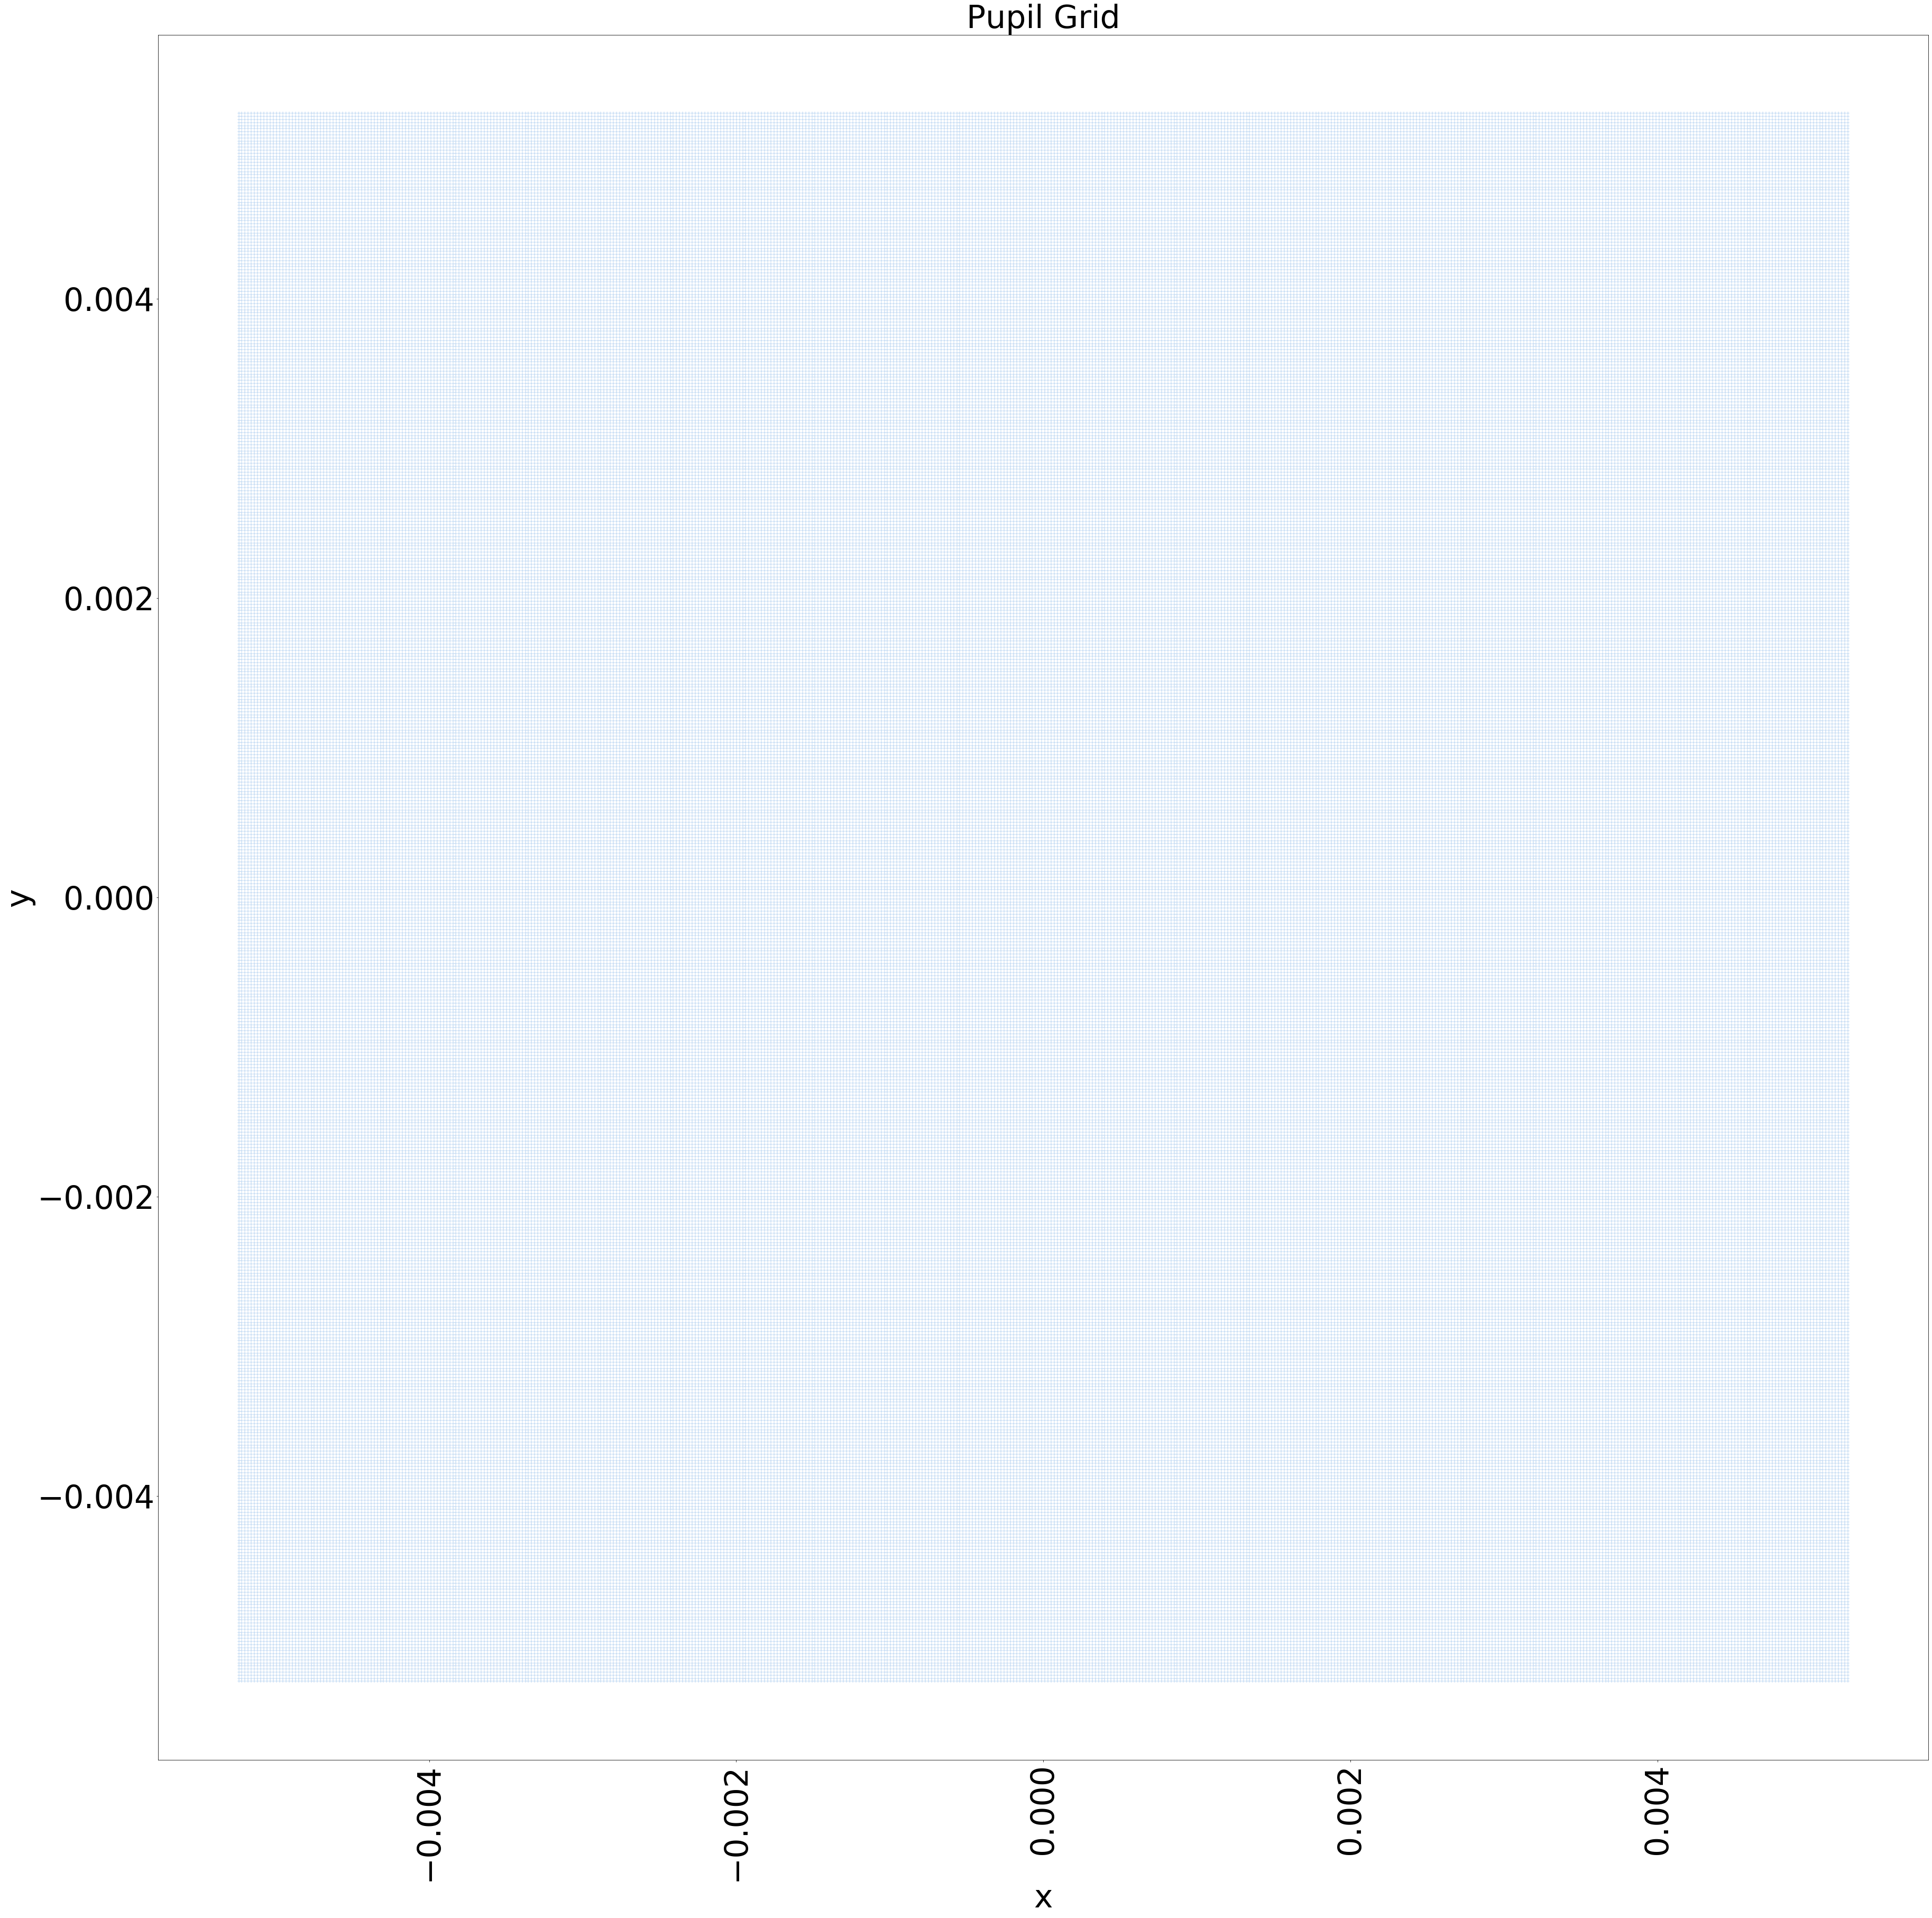

In [23]:
## Just plotting something
plt.figure(figsize=(60,60))
plt.plot(pupil_grid.x, pupil_grid.y, '+')
plt.title('Pupil Grid',fontsize=60)
xfont = plt.xlabel('x', fontsize=60)
yfont = plt.ylabel('y', fontsize=60)
xticks = plt.xticks(fontsize=60, rotation=90)
yticks = plt.yticks(fontsize=60, rotation=0)

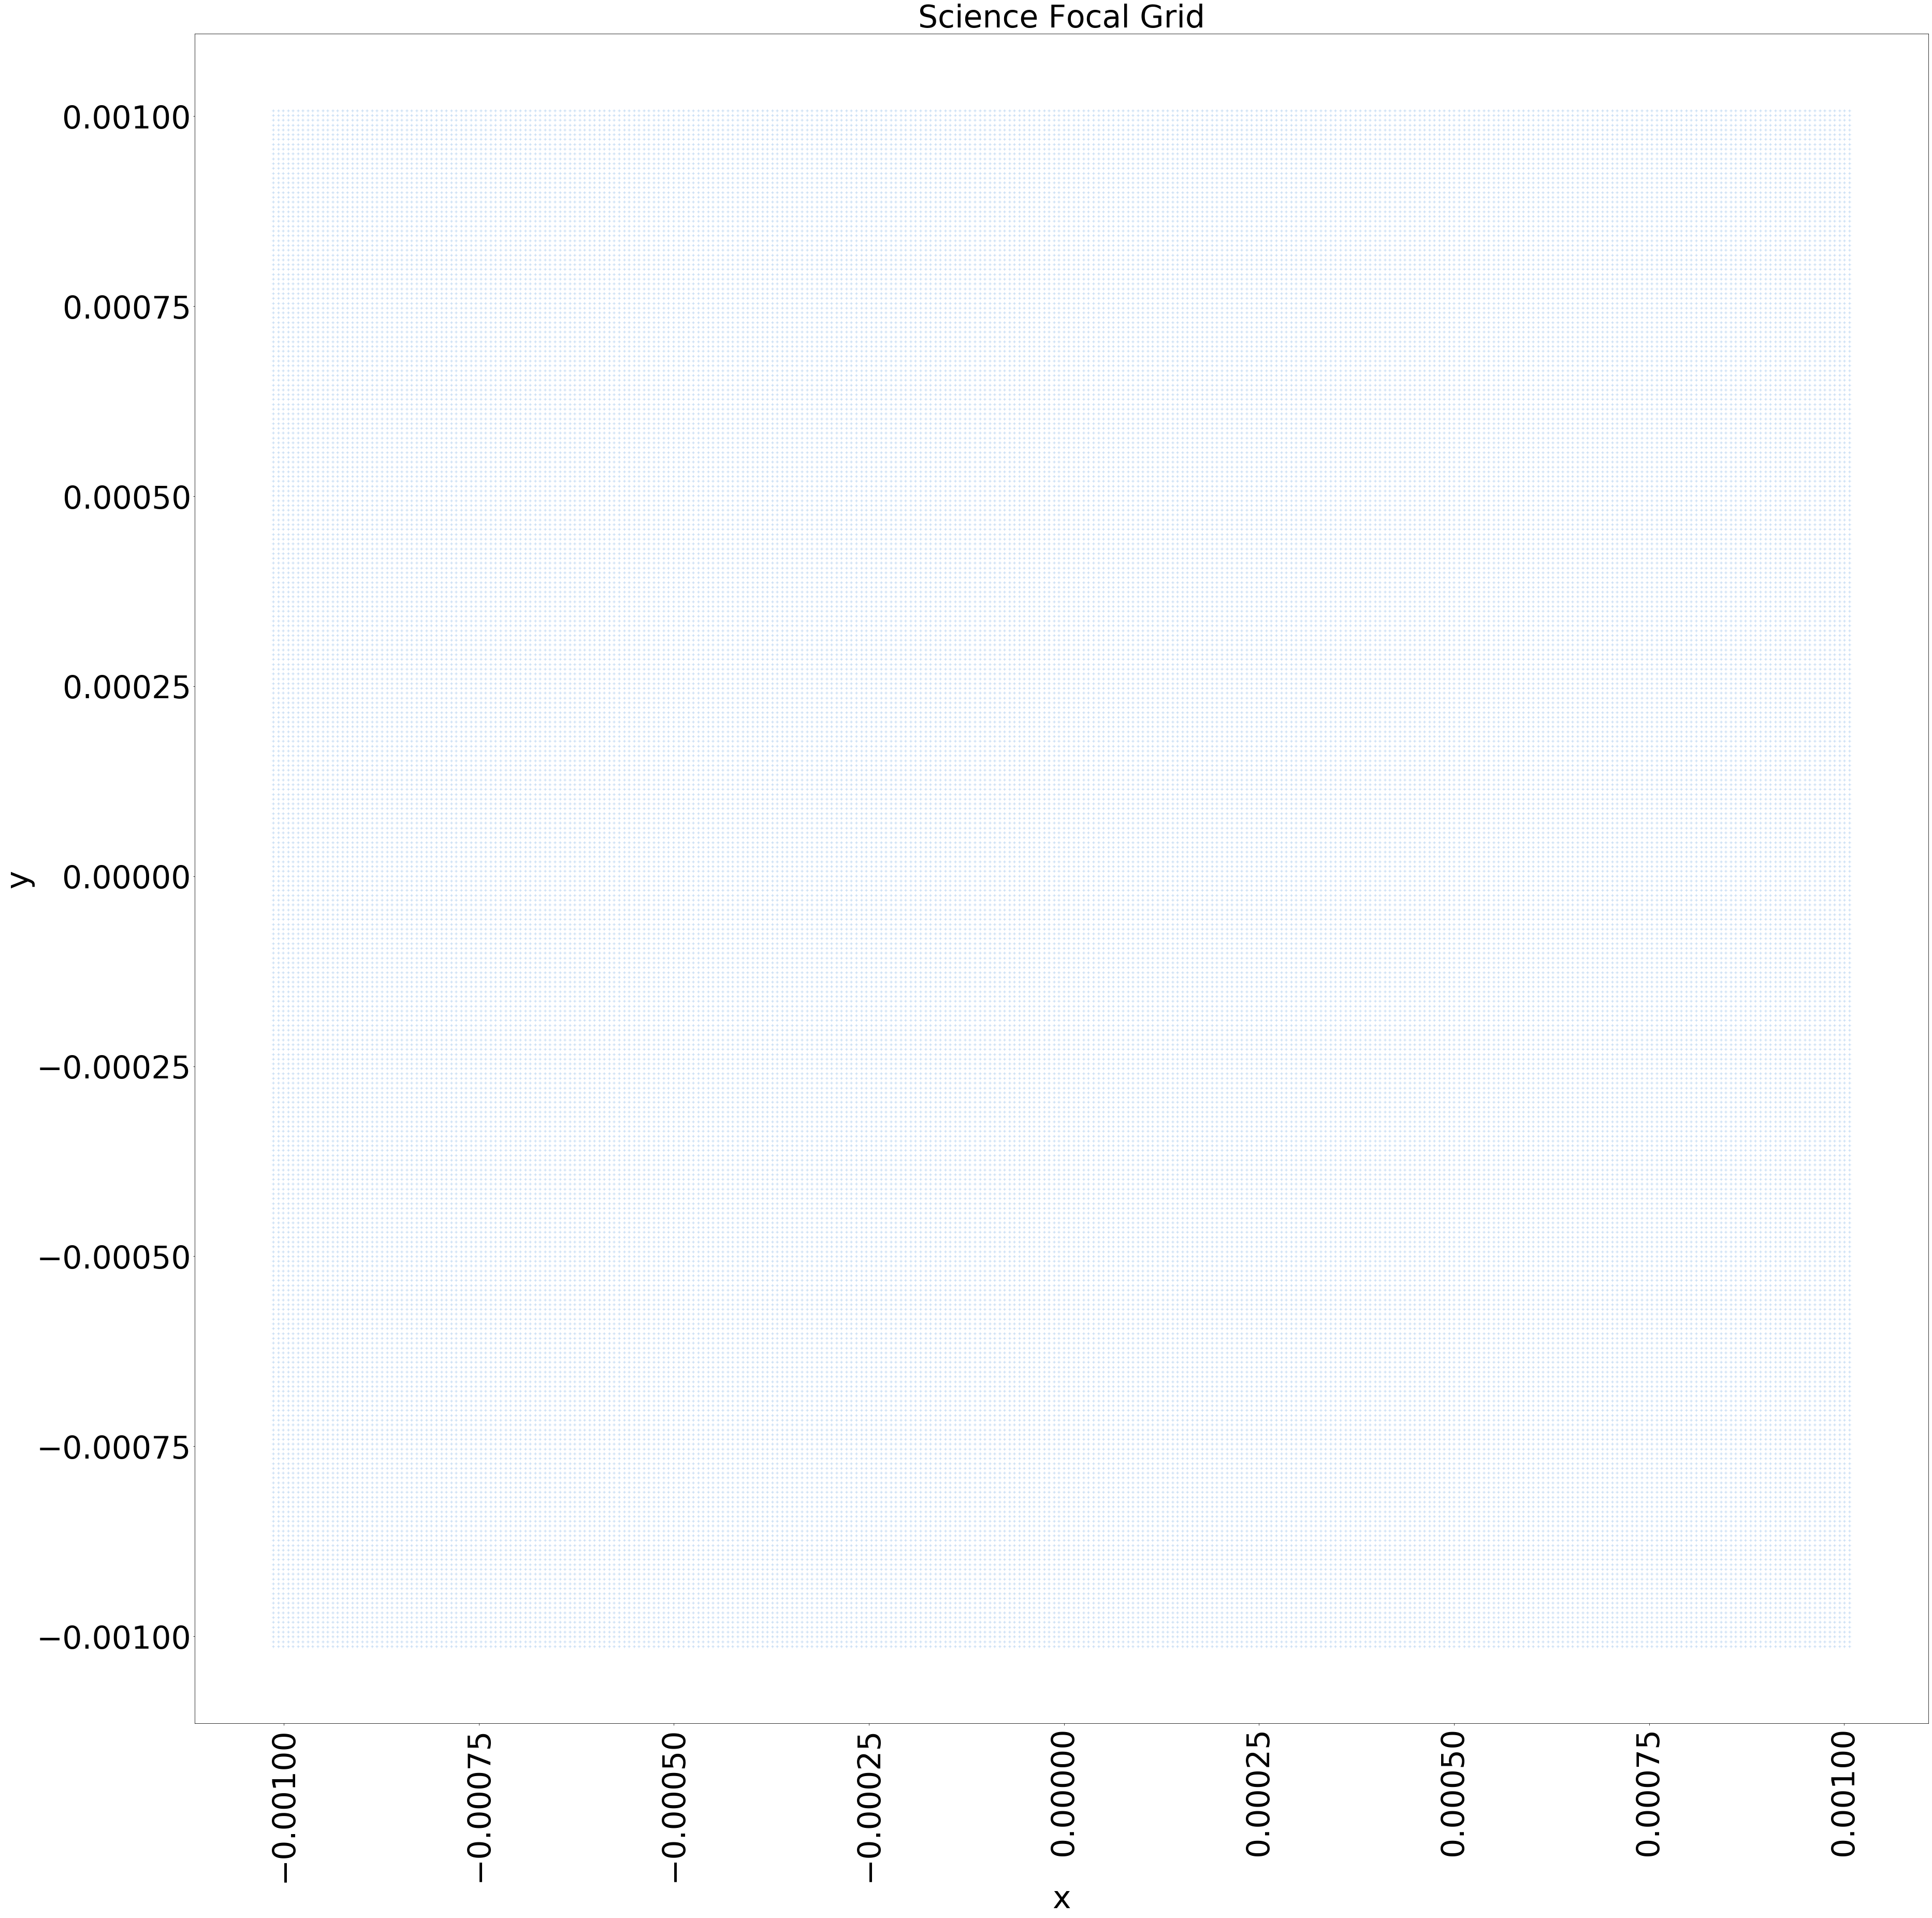

In [25]:
## Just plotting something
plt.figure(figsize=(60,60))
plt.plot(science_focal_grid.x, science_focal_grid.y, '+')
plt.title('Science Focal Grid',fontsize=60)
xfont = plt.xlabel('x', fontsize=60)
yfont = plt.ylabel('y', fontsize=60)
xticks = plt.xticks(fontsize=60, rotation=90)
yticks = plt.yticks(fontsize=60, rotation=0)

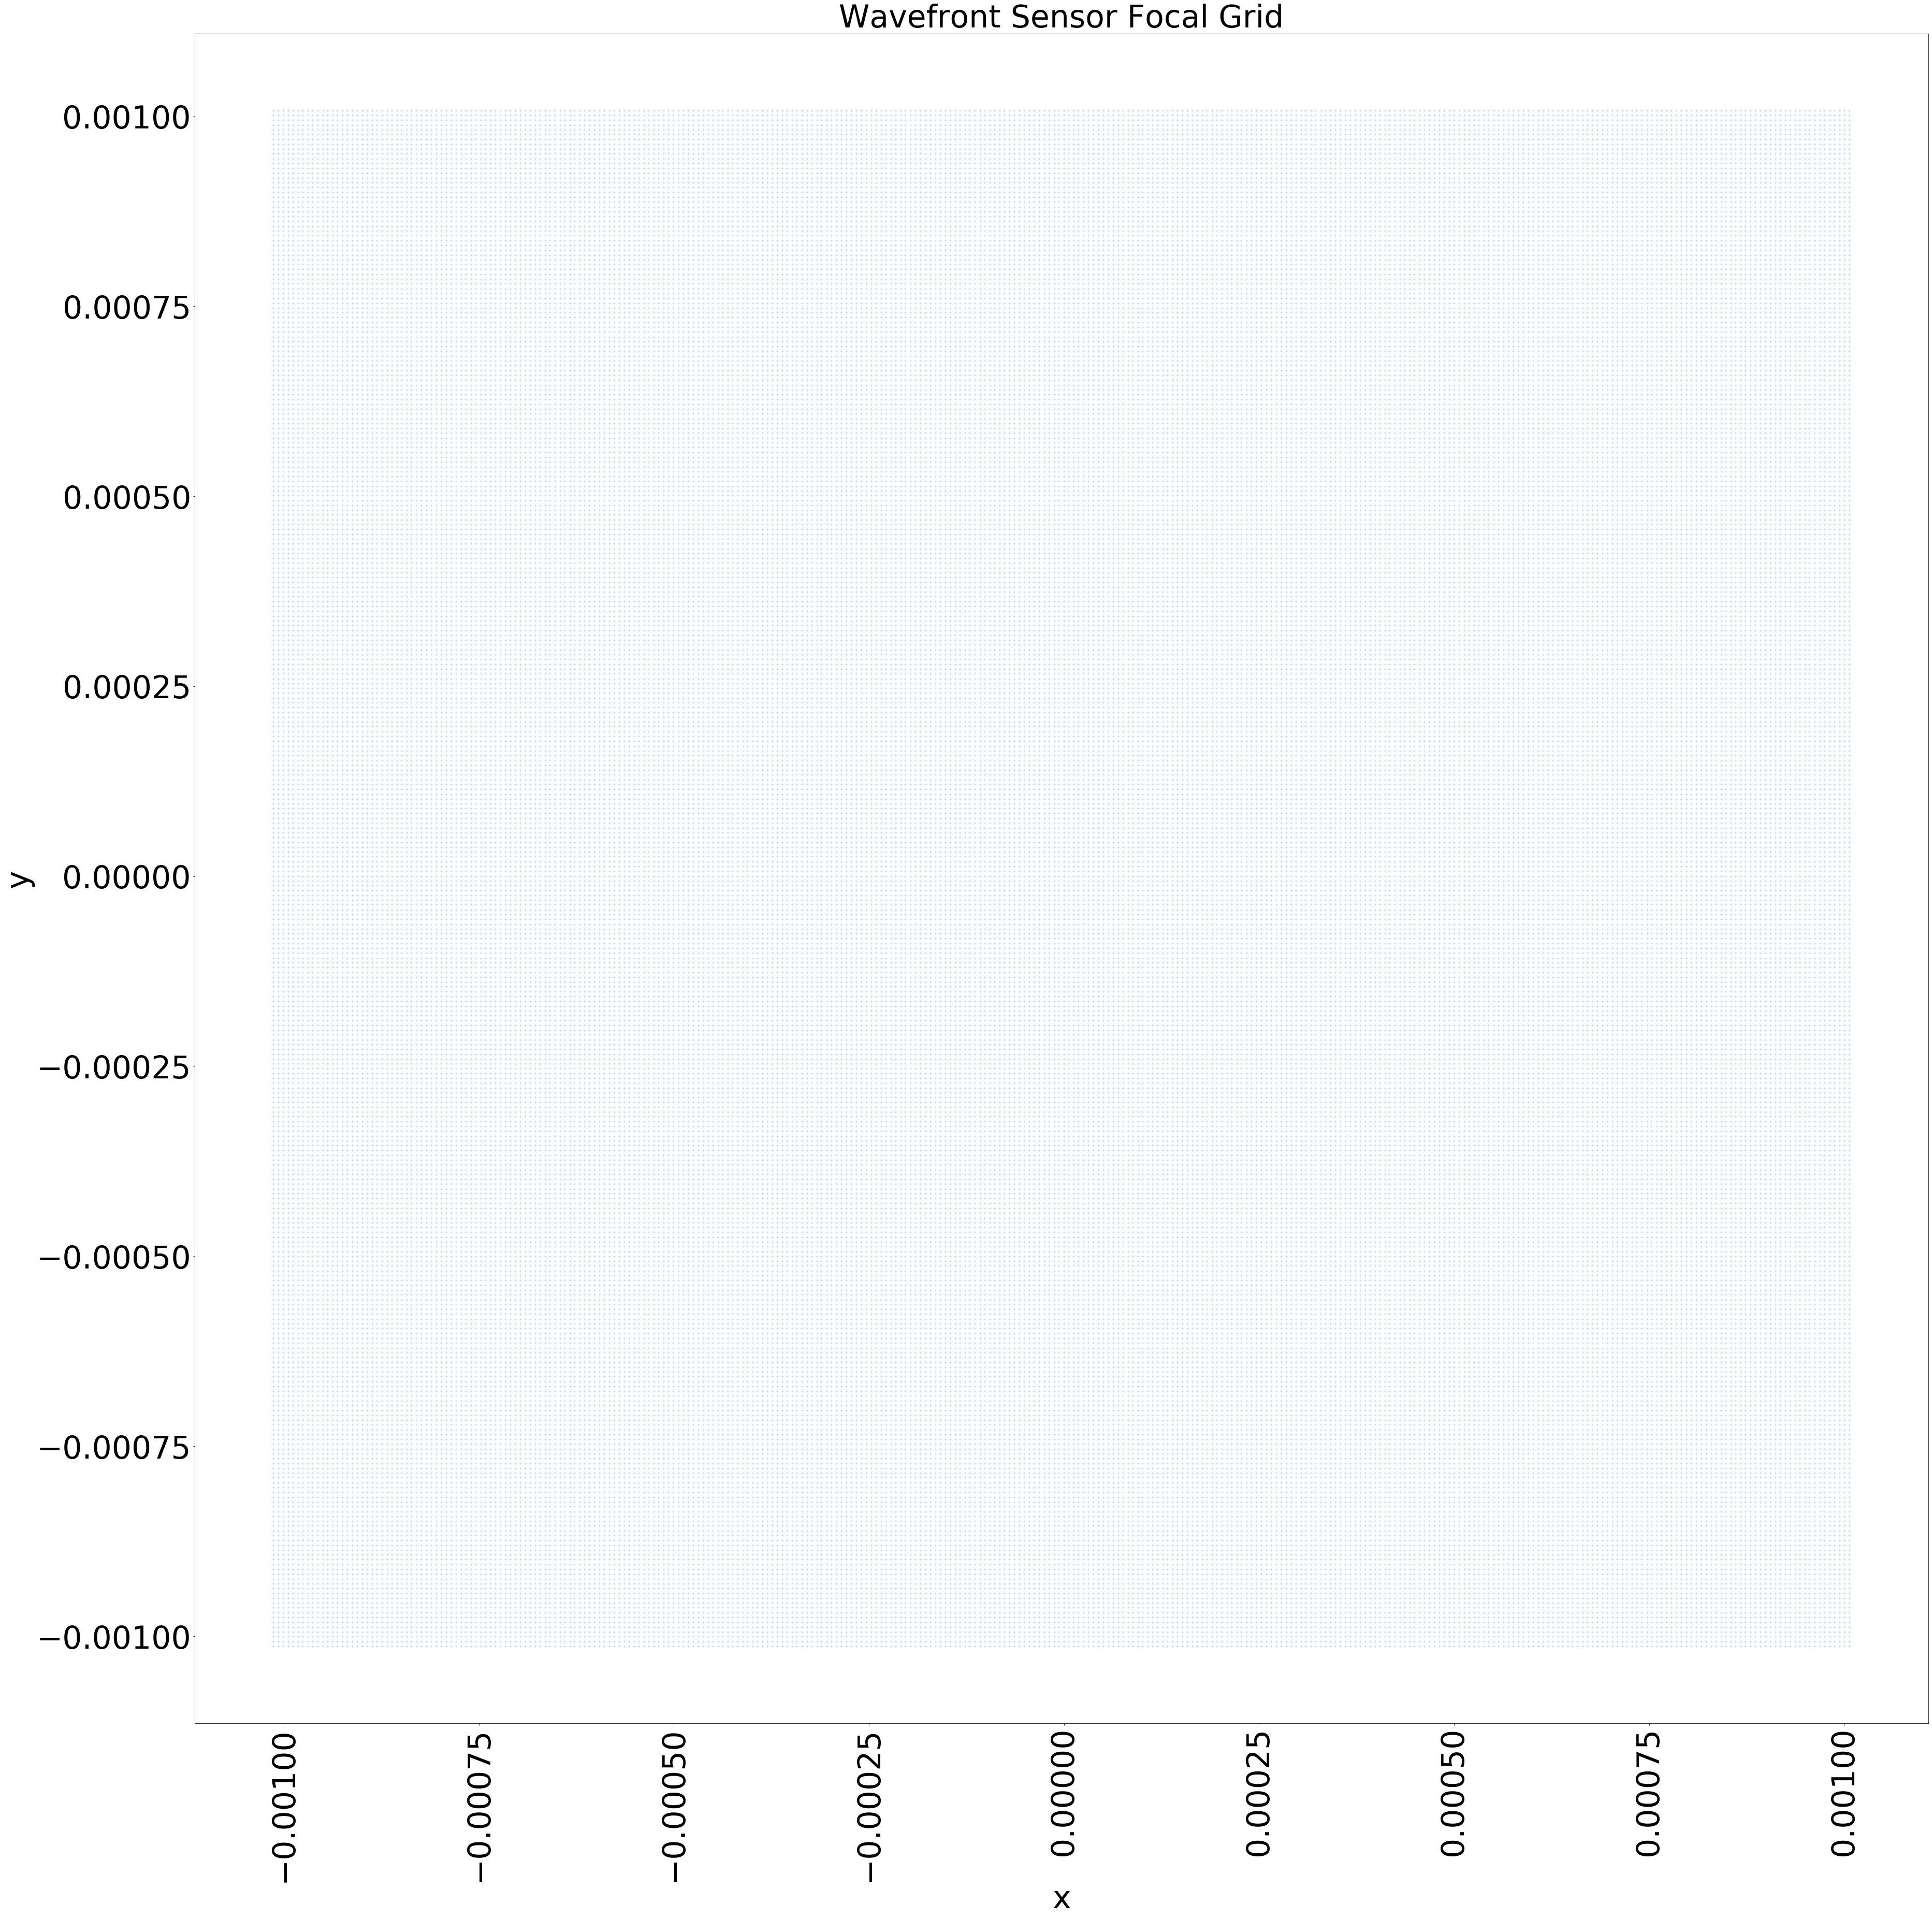

In [28]:
## Just plotting something
plt.figure(figsize=(60,60))
plt.plot(wfs_focal_grid.x, wfs_focal_grid.y, '+')
plt.title('Wavefront Sensor Focal Grid',fontsize=60)
xfont = plt.xlabel('x', fontsize=60)
yfont = plt.ylabel('y', fontsize=60)
xticks = plt.xticks(fontsize=60, rotation=90)
yticks = plt.yticks(fontsize=60, rotation=0)

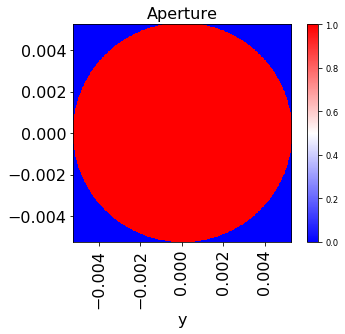

In [40]:
aperture = circular_aperture(D)
aperture_grid = aperture(pupil_grid)
imshow_field(aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Aperture', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

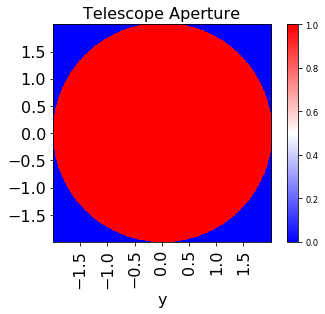

In [41]:
## Telescope parameters
Dtel = 4
tel_pupil_grid = make_pupil_grid(N, Dtel)
tel_aperture = circular_aperture(Dtel)
tel_aperture_grid = tel_aperture(tel_pupil_grid)
imshow_field(tel_aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Telescope Aperture', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

Num of modes in demformable mirror is 625


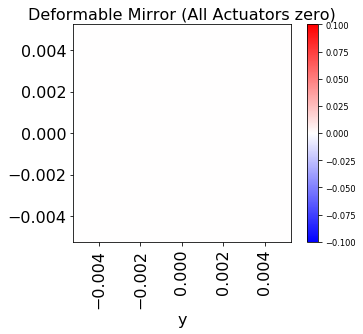

In [47]:
### Deformable mirror
n_actuator = 25
actuator_grid = make_pupil_grid(n_actuator, D*1.1)
sigma = D/n_actuator
gaussian_basis = make_gaussian_pokes(pupil_grid, actuator_grid, sigma)
dm = DeformableMirror(gaussian_basis)
num_modes = len(dm.influence_functions)
print('Num of modes in demformable mirror is {}'.format(num_modes))
dm.actuators = np.zeros(num_modes)
imshow_field(dm.surface, cmap = 'bwr')
plt.colorbar()
plt.title('Deformable Mirror (All Actuators zero)', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

In [77]:
# Atmosphere parameters
pixels_per_frame = 1
velocity = np.array([pixels_per_frame, 0])
L0 = 40
r0 =0.2
height = 0
Cn2 = Cn_squared_from_fried_parameter(r0, 500e-9)

# Make atmosphere
np.random.seed(42)
layers = []
layer = InfiniteAtmosphericLayer(tel_pupil_grid, Cn2, L0, 
                                 velocity* tel_pupil_grid.delta[0],
                                height, 2)

layer2 = ModalAdaptiveOpticsLayer(layer, dm.influence_functions, 1)
layers.append(layer2)
atmosphere = MultiLayerAtmosphere(layers, scintilation=True)


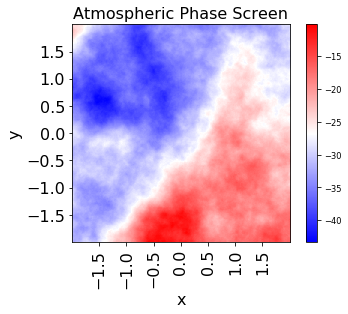

In [78]:
imshow_field(layer.phase_for(wavelength), cmap='bwr')
plt.colorbar()
plt.title('Atmospheric Phase Screen', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

In [108]:
## Now we will create WAVEFRONTS

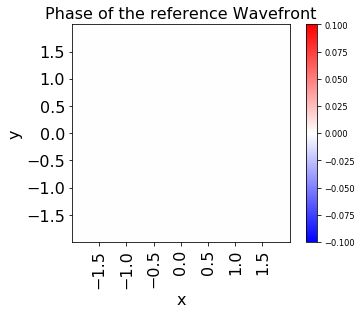

In [90]:
# Reference Wavefront

wf_tel = Wavefront(tel_aperture_grid, wavelength)
wf_tel.total_power = 1
imshow_field(wf_tel.phase, cmap='bwr')
plt.colorbar()
plt.title('Phase of the reference Wavefront', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


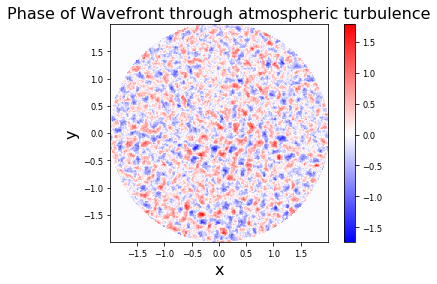

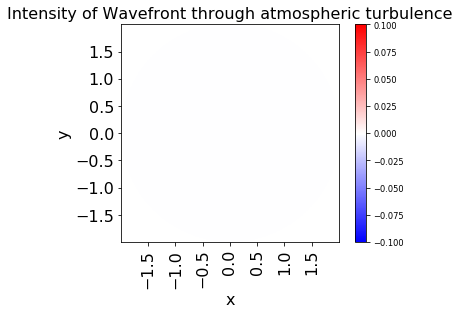

In [91]:
# Make initial phase screen
atms_time = 1 # Seconds ?
atmosphere.evolve_until(atms_time)
atms_time += 1
atmosphere.evolve_until(atms_time)

# Wavefront passes through atmosphere
wfatms_tel = atmosphere.forward(wf_tel)
f, (ax1) = plt.subplots(1, sharey=True)
#imshow_field(np.log10(wfatms_tel.intensity/wfatms_tel.intensity.max()), cmap='bwr')
imshow_field(wfatms_tel.phase,  cmap='bwr', ax = ax1)
plt.colorbar(ax=ax1)
xt = ax1.set_title('Phase of Wavefront through atmospheric turbulence', fontsize=16)
xl = ax1.set_xlabel('x', fontsize = 16)
yl = ax1.set_ylabel('y', fontsize = 16)
#xticks = ax1.set_xticklabels(fontsize=16, rotation=90)
#yticks = ax1.set_yticklabels(fontsize=16, rotation=0)



'''
WHY IS INTENSITY ZERO?
'''
plt.figure()
imshow_field(np.log10(wfatms_tel.intensity/wfatms_tel.intensity.max()), cmap='bwr')
plt.colorbar()
plt.title('Intensity of Wavefront through atmospheric turbulence', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

In [80]:
wfatms_tel.intensity

Field([0., 0., 0., ..., 0., 0., 0.])

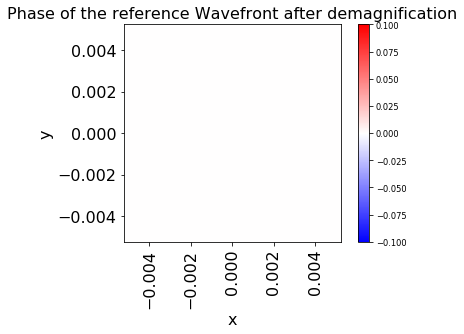

In [104]:
## Defamgnify the reference wavefront for the optics
mag = Magnifier(10.5e-3/4)
wfref_demagnified = mag.forward(wf_tel)

imshow_field(wfref_demagnified.phase, cmap='bwr')
plt.colorbar()
plt.title('Phase of the reference Wavefront after demagnification', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)





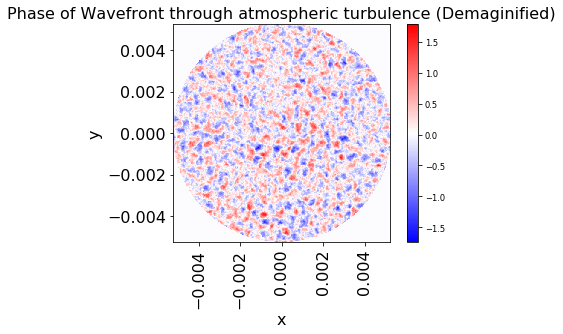

In [109]:
# Defamgnify the aberrated wavefront for the optics


wfatms_demagnified = mag.forward(wfatms_tel)
imshow_field(wfatms_demagnified.phase, cmap='bwr')
plt.colorbar()
plt.title('Phase of Wavefront through atmospheric turbulence (Demaginified)', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

In [83]:
# Now we will create a propagator from pupil plane to focal plane
prop = FraunhoferPropagator(pupil_grid, science_focal_grid, wavelength)


In [84]:
# So now create a detector, we don't need  appodization plate right now.
flatfield = 0.05 # 5% flat field error
darkcurrentrate = 2 # Dark current counts per second
readnoise = 100 # rms count per read out
photonnoise = True

# Create our detector
science_camera = NoiselessDetector()
shack_hartmann_camera = NoiselessDetector()

In [86]:
# Create the Shack-Hartmann Wavefront Sensor
# (mla stands for micro lens array)
F_mla = 40. /0.3 # F-Number (F-Number = Focal Length/Diameter)
N_mla = 22 # Number of lenslet
D_mla = 10.5e-3 # Pupil Diameter
'''
SquareShackHartmannWavefrontSensorOptics(
    input_grid,
    f_number,
    num_lenslets,
    pupil_diameter,
)
'''
shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid, F_mla,
                                                N_mla, D_mla)

'''
Init signature:
ShackHartmannWavefrontSensorEstimator(
    mla_grid,
    mla_index,
    estimation_subapertures=None,
)
Docstring:     
The estimator for a wavefront sensor.
Estimate the wavefront from images.

This object serves as the base class for all estimators in 
a wavefront sensor. It calculates from a list of images what
the wavefront is. This wavefront can be anything that responds
to wavefront changes, such as slopes, pupil amplitude, etc...
'''
shwse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid,
                                 shwfs.micro_lens_array.mla_index)

'''
QUESTION: WHAT ELSE WE CAN DO WITH 
SquareShackHartmannWavefrontSensorOptics
and ShackHartmannWavefrontSensorEstimator
'''



'\nQUESTION: WHAT ELSE WE CAN DO WITH \nSquareShackHartmannWavefrontSensorOptics\nand ShackHartmannWavefrontSensorEstimator\n'

Diffraction limited Wavefront power: [ 215.47156353  381.33889727 1825.48604115 ... 3020.37334142 3075.91443571
  174.47931422]


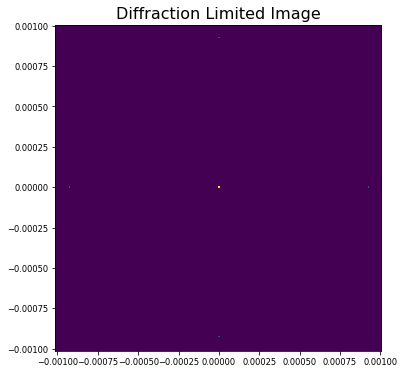

In [105]:
## Generate a diffraction limited image for metrics
diff_lim_wavefront = prop(wfref_demagnified)
diff_lim_img = diff_lim_wavefront.power
print('Diffraction limited Wavefront power: {}'.format(diff_lim_img))
plt.figure(figsize=(6,6))
imshow_field(diff_lim_img)
t= plt.title('Diffraction Limited Image', fontsize=16)



/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  


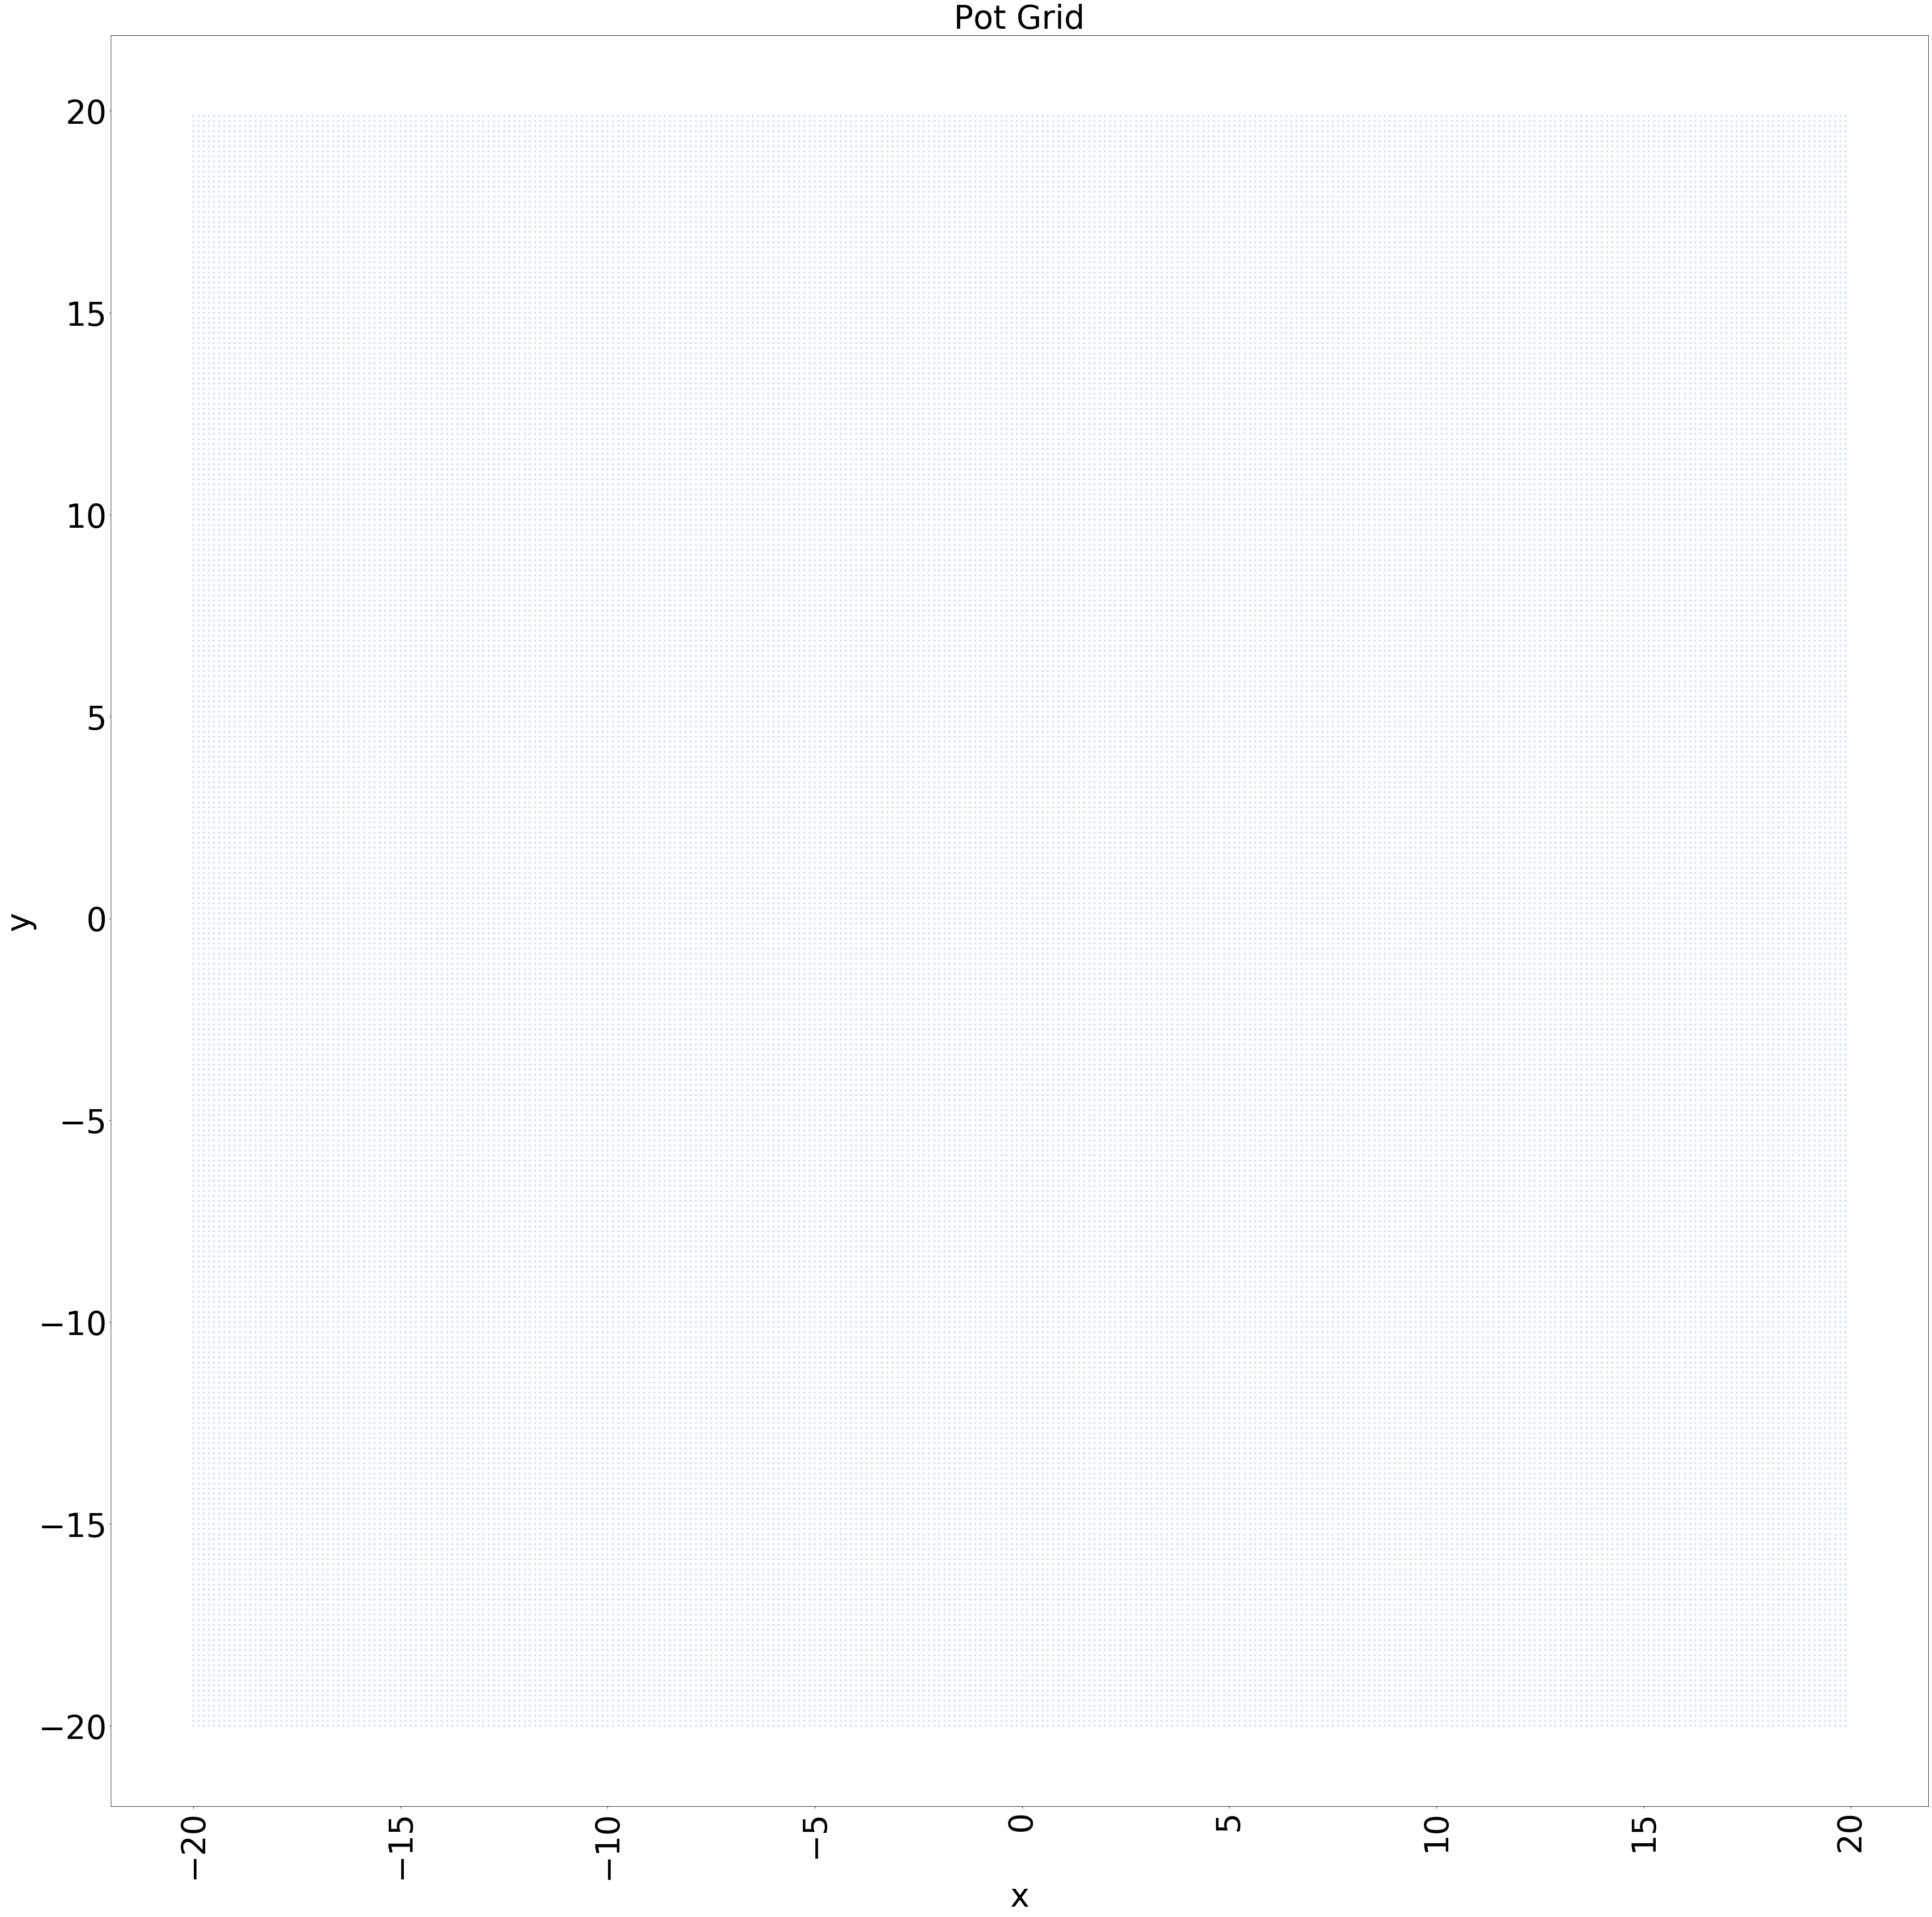

In [103]:
angular_resolution = wavelength/D

'''
DON'T KNOW WHAT IS PLOT GRID
'''
plot_grid = make_focal_grid(make_pupil_grid(512), 8, 20)
plt.figure(figsize=(60,60))
plt.plot(plot_grid.x, plot_grid.y, '+')
plt.title('Pot Grid',fontsize=60)
xfont = plt.xlabel('x', fontsize=60)
yfont = plt.ylabel('y', fontsize=60)
xticks = plt.xticks(fontsize=60, rotation=90)
yticks = plt.yticks(fontsize=60, rotation=0)

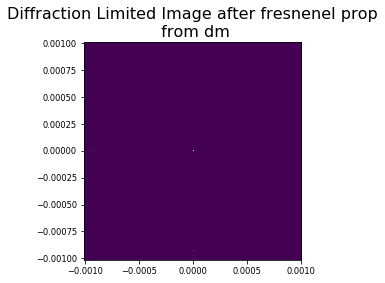

In [106]:
wfrefdm = dm.forward(wfref_demagnified)
wfrefdm_img = prop(wfrefdm)
wfref_img_power = wfrefdm.power
imshow_field(wfref_img_power)
t= plt.title('Diffraction Limited Image after fresnenel prop\n from dm', fontsize=16)

In [107]:
## AO Control goes here
cost_function = []
strehl_ratio = []
modes_evolution = []
lrate_evolution = []

# Reset the learning rate, gradients and perturbatory sequency
lrate = 1e-6
amp = 1e-10
merit = 999.99
grads = np.zeros(dm.actuators.size,)
np.random.seed(42)

In [112]:
## Create a spatial filter
filt_aperture = circular_aperture(25)
spatial_filter = Apodizer(filt_aperture(science_focal_grid))

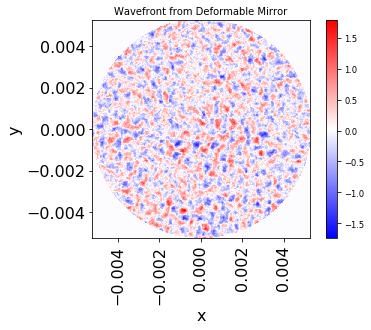

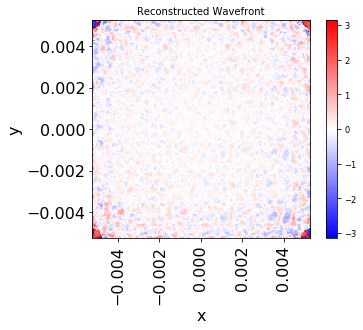

In [116]:
iterations = 1

for loop in np.arange(iterations):
    dm_wf = dm.forward(wfatms_demagnified)
    
    
    # Science Optical Path here
    prop_dm_wf = prop(dm_wf)
    science_camera.integrate(prop_dm_wf, 1, 1)
    science_image = science_camera.read_out()
    #imshow_field(np.log10(science_image), vmax=np.log10(science_image).max(), vmin=0)
    #plt.title('science image')
    #plt.colorbar()
    #plt.show()
    
    
    imshow_field(dm_wf.phase, cmap='bwr')
    #plt.title('Wavefront from Deformable Mirror')
    #plt.colorbar()
    #plt.xlabel('x', fontsize = 16)
    #plt.ylabel('y', fontsize = 16)
    #xticks = plt.xticks(fontsize=16, rotation=90)
    #yticks = plt.yticks(fontsize=16, rotation=0)
    #plt.show()
    
    # Wavefront sensor Optical Path
    # Implemented spatial filter to simulate reconstructed wavefront
    reconstructed_wf = prop.backward(spatial_filter.forward(prop_dm_wf))
    #imshow_field(reconstructed_wf.phase, cmap='bwr')
    #plt.title('Reconstructed Wavefront')
    #plt.colorbar()
    #plt.xlabel('x', fontsize = 16)
    #plt.ylabel('y', fontsize = 16)
    #xticks = plt.xticks(fontsize=16, rotation=90)
    #yticks = plt.yticks(fontsize=16, rotation=0)
    #plt.show()
    
    # Control Path goes here
    